<a href="https://colab.research.google.com/github/MatteoFusconi/Artificial-Intelligence-master/blob/main/Project/EmotionFlipReasoning_forse_va.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Flip Reasoning
**Authors**: Chiara Angileri, Matteo Fusconi, Niccolò Marzi, Shola Oshodi

## 0. Importing libraries

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from collections import Counter, defaultdict
from torch.nn.utils.rnn import pad_sequence
import random

from tqdm import tqdm

from google.colab import drive

drive.mount('/content/drive')

data_folder = Path.cwd() / "drive" / "MyDrive" / "SemEval24"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
seed = 42

def fix_random(seed):
    """Fix all the possible sources of randomness.
        :param seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed)

## 1. Corpus loading and exploration

### 1.1. Corpus loading

In [26]:
'''train_path = data_folder.joinpath("MELD_train_efr.json")
val_path = data_folder.joinpath("MELD_val_efr.json")
test_path = data_folder.joinpath("MELD_test_efr.json")

train_df = pd.read_json(train_path)
val_df = pd.read_json(val_path)
test_df = pd.read_json(test_path)
'''

dataset_path = data_folder.joinpath("MELD_train_efr.json")
dataset = pd.read_json(dataset_path)

#Split in train (80%) and test + validation (20%)
train_df, test_val_df = train_test_split(dataset, test_size=0.2, shuffle=False)

#Split validation and test (10% each w.r.t. the original dataset)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, shuffle=False)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [27]:
print(f"The train set has {len(train_df)} examples")
print(f"The val set has {len(val_df)}  examples")
print(f"The test set has {len(test_df)} examples")

The train set has 3200 examples
The val set has 400  examples
The test set has 400 examples


In [28]:
train_df.head()

,episode,speakers,emotions,utterances,triggers
0,utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


In [29]:
# Deal with missing values: trigger= None --> 0
def fillNone(l: list):
  return [x if type(x) == float else 0. for x in l]

train_df["triggers"] = train_df["triggers"].apply(fillNone)
val_df["triggers"] = val_df["triggers"].apply(fillNone)

In [30]:
unique_emotions = set()
for emotions_list in train_df['emotions']:
    unique_emotions.update(emotions_list)

unique_emotions = sorted(unique_emotions)
unique_emotions

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

### 1.1. Dataset inspection

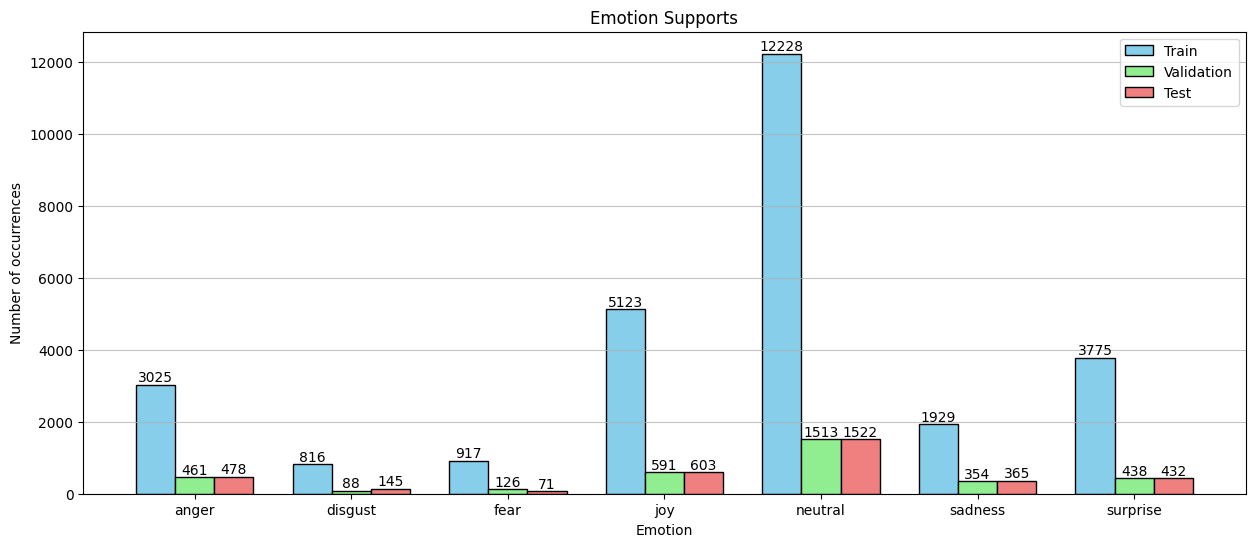

In [31]:
train_support = [sum(sublist.count(name) for sublist in train_df["emotions"]) for name in unique_emotions]
validation_support = [sum(sublist.count(name) for sublist in val_df["emotions"]) for name in unique_emotions]
test_support = [sum(sublist.count(name) for sublist in test_df["emotions"]) for name in unique_emotions]

plt.figure(figsize=(15, 6))
bar_width = 0.25
index = range(len(unique_emotions))

bars1 = plt.bar(index, train_support, width=bar_width, color='skyblue', edgecolor='black', label='Train')
bars2 = plt.bar([i + bar_width for i in index], validation_support, width=bar_width, color='lightgreen', edgecolor='black', label='Validation')
bars3 = plt.bar([i + 2 * bar_width for i in index], test_support, width=bar_width, color='lightcoral', edgecolor='black', label='Test')

# Adding the count above each bar
for bars in [bars1, bars2, bars3]:
      for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')
plt.title('Emotion Supports')
plt.xlabel('Emotion')
plt.ylabel('Number of occurrences')
plt.xticks([i + bar_width for i in index], unique_emotions)
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()



In [32]:
# Function to process the data and count emotion flips
def count_emotion_flips(data):
    # Initialize a dictionary to hold the counts of emotion flips
    emotion_flip_counts = defaultdict(lambda: defaultdict(int))

    # Iterate through each record in the data
    for record in data.iterrows():
        emotions = record[1]['emotions']
        # Iterate through the emotions and count flips
        for i in range(1, len(emotions)):
            # Check if there is a flip (change in emotion)
            if emotions[i] != emotions[i-1]:
                emotion_flip_counts[emotions[i-1]][emotions[i]] += 1

    # Convert defaultdict to a regular dict for easier use later
    emotion_flip_counts = {k: dict(v) for k, v in emotion_flip_counts.items()}
    return emotion_flip_counts

# Process the emotion flip data
emotion_flip_counts = count_emotion_flips(train_df)

# Initialize a DataFrame to hold the counts, with rows and columns as unique emotions
emotion_flip_df = pd.DataFrame(0, index=unique_emotions, columns=unique_emotions)

# Fill the DataFrame with the counts from emotion_flip_counts
for source_emotion, target_emotions in emotion_flip_counts.items():
    for target_emotion, count in target_emotions.items():
        emotion_flip_df.at[source_emotion, target_emotion] = count

# Add a 'Total' row and column to the DataFrame
emotion_flip_df.loc['Total',:] = emotion_flip_df.sum(axis=0)
emotion_flip_df.loc[:,'Total'] = emotion_flip_df.sum(axis=1)

# Show the DataFrame and the HTML table
emotion_flip_df.astype(int)

,anger,disgust,fear,joy,neutral,sadness,surprise,Total
anger,0,74,108,323,925,192,303,1925
disgust,120,0,39,48,244,50,118,619
fear,110,11,0,81,348,55,64,669
joy,303,103,134,0,1801,234,527,3102
neutral,1000,298,292,1762,0,613,1537,5502
sadness,163,54,63,207,526,0,270,1283
surprise,361,111,97,517,1385,250,0,2721
Total,2057,651,733,2938,5229,1394,2819,15821


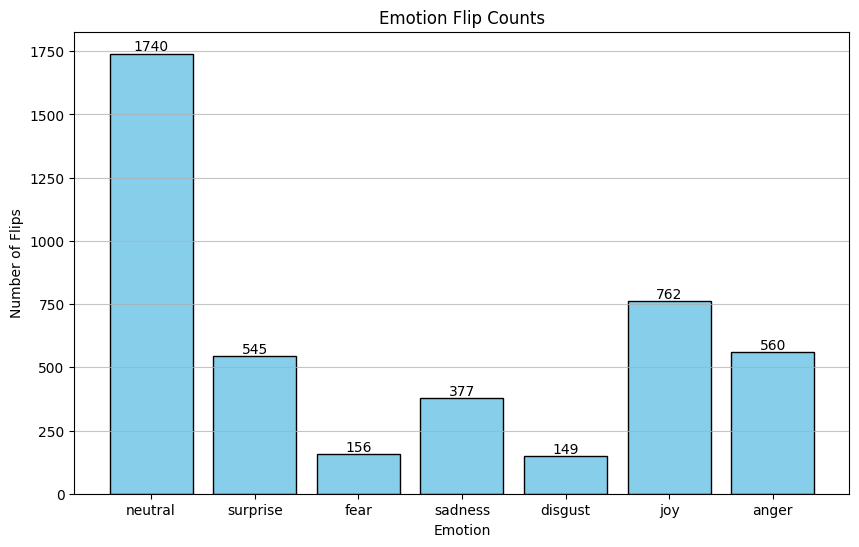

In [33]:
# Function to count emotion flips for each emotion
def count_emotion_flips(emotions, triggers):
    return Counter(emotion for emotion, trigger in zip(emotions, triggers) if trigger == 1)

# Counting emotion flips for each emotion in the dataset
emotion_flip_counts = Counter()
for emotions, triggers in zip(train_df['emotions'], train_df['triggers']):
    emotion_flip_counts.update(count_emotion_flips(emotions, triggers))

emotions = list(emotion_flip_counts.keys())
flip_counts = list(emotion_flip_counts.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(emotions, flip_counts, color='skyblue', edgecolor='black')

# Adding the count above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.title('Emotion Flip Counts')
plt.xlabel('Emotion')
plt.ylabel('Number of Flips')
plt.grid(axis='y', alpha=0.75)
plt.show()

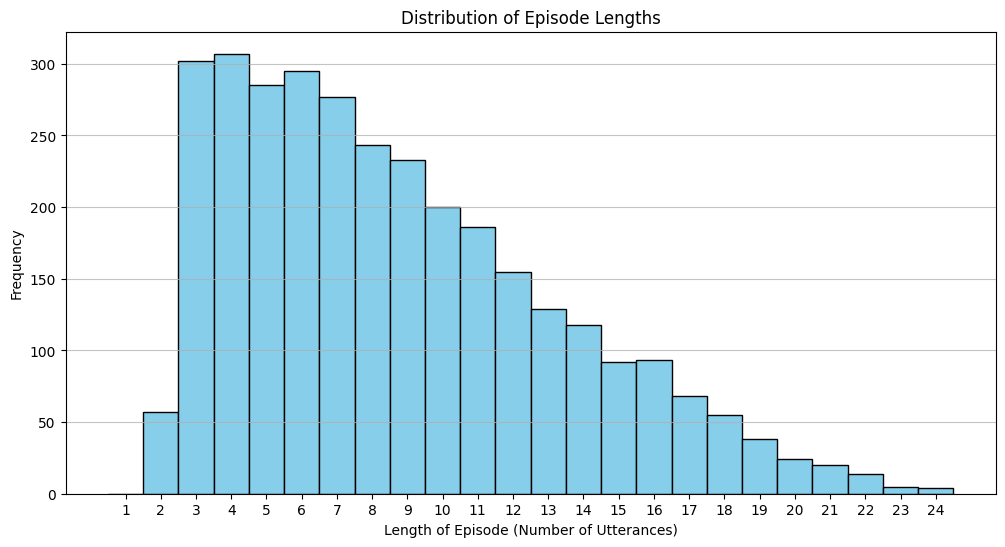

,utterances
count,3200.000000
mean,8.691562
std,4.592169
min,2.000000
25%,5.000000
50%,8.000000
75%,12.000000
max,24.000000


In [34]:
# Calculating the length of each episode (number of utterances)
episode_lengths = train_df['utterances'].apply(len)

episode_lengths_stats = episode_lengths.describe()

max_length = episode_lengths.max()

plt.figure(figsize=(12, 6))
plt.hist(episode_lengths, bins=range(1, max_length + 2), color='skyblue', edgecolor='black')
plt.title('Distribution of Episode Lengths')
plt.xlabel('Length of Episode (Number of Utterances)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(1.5, max_length + 1.5), labels= np.arange(1, max_length + 1))
plt.show()

pd.DataFrame(episode_lengths_stats)

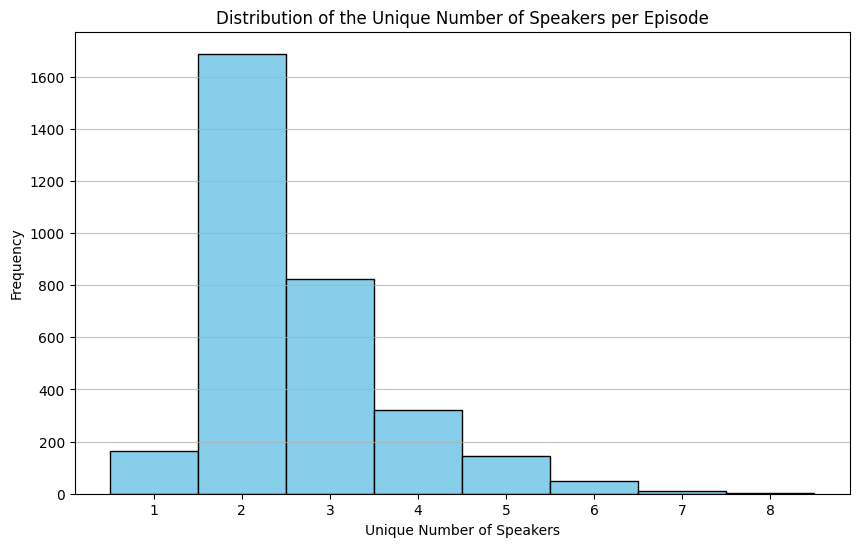

,speakers
count,3200.000000
mean,2.617188
std,1.026387
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,8.000000


In [35]:
# Counting the unique number of speakers per episode
unique_speakers_per_episode = train_df['speakers'].apply(lambda x: len(set(x)))

# Descriptive Statistics for the unique number of speakers per episode
unique_speakers_stats = unique_speakers_per_episode.describe()

# Plotting the distribution of the unique number of speakers per episode
plt.figure(figsize=(10, 6))
plt.hist(unique_speakers_per_episode, bins=range(1, unique_speakers_per_episode.max() + 2), color='skyblue', edgecolor='black')
plt.title('Distribution of the Unique Number of Speakers per Episode')
plt.xlabel('Unique Number of Speakers')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(1.5, unique_speakers_per_episode.max() + 1.5), range(1, unique_speakers_per_episode.max() + 1))
plt.show()

pd.DataFrame(unique_speakers_stats)

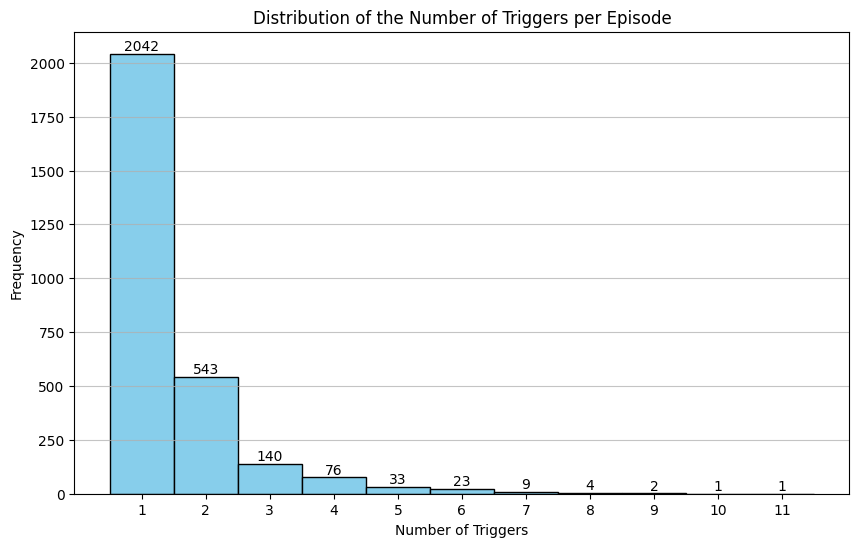

,triggers
count,3200.000000
mean,1.340313
std,1.071732
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,11.000000


In [36]:
n_triggers_per_episode = train_df['triggers'].apply(lambda x: int(sum(x)))

triggers_stats = n_triggers_per_episode.describe()

# Plotting the distribution of the unique number of speakers per episode
plt.figure(figsize=(10, 6))
hist = plt.hist(n_triggers_per_episode, bins=range(1, n_triggers_per_episode.max() + 2), color='skyblue', edgecolor='black')
plt.title('Distribution of the Number of Triggers per Episode')
plt.xlabel('Number of Triggers')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(1.5, n_triggers_per_episode.max() + 1.5), range(1, n_triggers_per_episode.max() + 1))
for bar in hist[2]:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')
plt.show()

pd.DataFrame(triggers_stats)

## 2. Data PreProcessing

### 2.1) Ordinal Encoding of the Speakers
For our purpose, the information of the speaker can actually be useful. It doesn't matter what is the name of the speaker, but we only care to distinguish them one another in each utterance separately.

In [37]:
def mapList(l: list):
  map_dict = {speaker: idx for idx, speaker in enumerate(set(l))}
  map_fun = lambda x: map_dict.get(x, x)
  return list(map(map_fun, l))

speakers_ordinal_train = train_df["speakers"].apply(mapList)
speakers_ordinal_val = val_df["speakers"].apply(mapList)
speakers_ordinal_test = test_df["speakers"].apply(mapList)

### 2.2) One Hot Encoding of the Emotions

For example, the sequence ["anger", "joy", "anger"] will be mapped into 7 sequences, each one for each emotion.
- "anger" will be [1,0,1]
- "joy" will be [0,1,0]
- others will be [0,0,0]

In [38]:
emotion_mapping = {idx: emotion for idx, emotion in enumerate(unique_emotions)}

def encode_emotions(emotions_col: pd.core.series.Series):
  emotions_series_list = []
  for emotion in unique_emotions:

    map_fun = lambda x: 1 if x == emotion else 0
    encode_emotion = lambda l : list(map(map_fun, l))

    emotion_series = emotions_col.apply(encode_emotion)
    emotion_series.name = emotion

    emotions_series_list.append(emotion_series)

  return pd.DataFrame({series.name: series for series in emotions_series_list})

emotions_ohe_train_df = encode_emotions(train_df["emotions"])
emotions_ohe_val_df = encode_emotions(val_df["emotions"])
emotions_ohe_test_df = encode_emotions(test_df["emotions"])

emotions_ohe_train_df

,anger,disgust,fear,joy,neutral,sadness,surprise
0,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 1]"
1,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]"
4,"[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[1, 0, 1, 0]"
...,...,...,...,...,...,...,...
3195,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 1, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0, 0, 0, 1, 0, 1]","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
3196,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]","[0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3197,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 0]","[0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0]"
3198,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 0, 0]","[0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0]"


In [39]:
speakers_ordinal_train_df = pd.DataFrame(speakers_ordinal_train)
speakers_ordinal_val_df = pd.DataFrame(speakers_ordinal_val)
speakers_ordinal_test_df = pd.DataFrame(speakers_ordinal_test)

speakers_ordinal_train_df

,speakers
0,"[1, 0, 1, 0, 1]"
1,"[1, 0, 1, 0, 1, 0, 1]"
2,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]"
3,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]"
4,"[0, 1, 0, 1]"
...,...
3195,"[3, 1, 1, 1, 2, 3, 0, 2, 1, 3]"
3196,"[3, 1, 1, 1, 2, 3, 0, 2, 1, 3, 2]"
3197,"[2, 1, 1, 0, 1, 1]"
3198,"[2, 1, 1, 0, 1, 1, 1]"


In [40]:
new_train_df = pd.concat([speakers_ordinal_train_df, train_df[['utterances','triggers']], emotions_ohe_train_df], axis=1)
new_val_df = pd.concat([speakers_ordinal_val_df, val_df[['utterances','triggers']], emotions_ohe_val_df], axis=1)
new_test_df = pd.concat([speakers_ordinal_test_df, test_df[['utterances','triggers']], emotions_ohe_test_df], axis=1)

new_train_df.head()

,speakers,utterances,triggers,anger,disgust,fear,joy,neutral,sadness,surprise
0,"[1, 0, 1, 0, 1]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[1, 1, 1, 1, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 1]"
1,"[1, 0, 1, 0, 1, 0, 1]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0]"
2,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
3,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]"
4,"[0, 1, 0, 1]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 1, 0, 0]","[1, 0, 1, 0]"


In [41]:
#Maximum utterance legth

episodes = list(train_df['utterances'])

UTT_MAX_LEN = 0

for episode in episodes:
  for utterance in episode:
    if len(utterance) > UTT_MAX_LEN:
      UTT_MAX_LEN = len(utterance)

print("The maximum utterance length accross the dataset is:", UTT_MAX_LEN)

The maximum utterance length accross the dataset is: 327


In [42]:
def order_df_by_len(ds):
  """
  Orders the dialogues by their length
  """
  ds['length'] = ds['utterances'].apply(len)
  return ds.sort_values(by='length').reset_index(drop=True).iloc[:,:-1]

In [43]:
new_train_df = order_df_by_len(new_train_df)
new_test_df = order_df_by_len(new_test_df)
new_val_df = order_df_by_len(new_val_df)

In [44]:
# new_train_df.speakers[300][1]

In [45]:
list(zip([1,2], [0]))

[(1, 0)]

In [46]:
new_train_df.iloc[300:303]

,speakers,utterances,triggers,anger,disgust,fear,joy,neutral,sadness,surprise
300,"[1, 0, 0]","[Let go!, No! You let go!, How come it's alway...","[0.0, 0.0, 0.0]","[1, 1, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 1]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
301,"[1, 0, 1]","[Uh... Oh, Mindy, you are so stupid. Oh, we ar...","[0.0, 1.0, 0.0]","[0, 0, 0]","[1, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 1, 1]","[0, 0, 0]","[0, 0, 0]"
302,"[0, 1, 0]","[You don't know?! Rach, you balded my girlfrie...","[1.0, 1.0, 0.0]","[0, 1, 1]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[1, 0, 0]","[0, 0, 0]","[0, 0, 0]"


In [58]:
tokenizer(new_train_df["utterances"].iloc[1])

{'input_ids': [[101, 3100, 1010, 2021, 2023, 2003, 1996, 2197, 2051, 1012, 102], [101, 2007, 1037, 14556, 1011, 14556, 2182, 1010, 1998, 1037, 14556, 1011, 14556, 2045, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [107]:
from torch.utils.data import Dataset, DataLoader

class TokenizerDataset(Dataset):
  '''
    This class is used to tokenize the dataset and create the dataloaders.
  '''
  def __init__(self, dataframe, tokenizer, utt_max_len = None):

    self.tokenizer = tokenizer
    self.data = dataframe

    self.utterances = self.data.utterances

    self.data["tokenized_utterances"] = self.data["utterances"].apply(lambda x: self.tokenizer(x)["input_ids"])

    self.data["lengths"] = self.data.tokenized_utterances.apply(lambda x: [len(y) for y in x])

    # display(self.data[["tokenized_utterances", "lengths"]])

    self.num_past_utterances = 2
    self.num_future_utterances = 2

    self._encode_dialogues()

    self.utt_max_len = utt_max_len

  def _encode_dialogues(self):
    # CLS = "<s>"
    # EOS = "</s>"
    # SEP = "<i>"

    max_tokens = 512 - 2 # Roberta max = 512 - 2(end and begin tokens)

    # returns the speaker of the given dialogue of the given utterance
    speaker = lambda idx_dia, idx_utt: str(self.data.speakers[idx_dialogue][idx_utt])

    final_utterances = []
    inputs = []

    for idx_dialogue, dialogue in enumerate(self.utterances):

      num_tokens = self.data.lengths.iloc[idx_dialogue]
      for idx_utt, utt in enumerate(dialogue):
        ues = dialogue
        ue = utt

        num_past_utterances = 2
        num_future_utterances = 2
        max_model_input_size = 512
        offset = 0

        indexes = [idx_utt]
        indexes_past =   list(range(idx_utt - 1, max(idx_utt - self.num_past_utterances  - 1, 0), -1))                # [t - 2 : t]
        indexes_future = list(range(idx_utt + 1, min(idx_utt + self.num_future_utterances + 1, len(dialogue)), 1))     # [t : t + 2]

        if len(indexes_past) < len(indexes_future):
            for _ in range(len(indexes_future) - len(indexes_past)):
                indexes_past.append(None)
        elif len(indexes_past) > len(indexes_future):
            for _ in range(len(indexes_past) - len(indexes_future)):
                indexes_future.append(None)

        for i, j in zip(indexes_past, indexes_future):
            if i is not None and i >= 0:
                indexes.insert(0, i)
                offset += 1
                if (
                    sum([num_tokens[idx_] for idx_ in indexes])
                    > max_model_input_size
                ):
                    del indexes[0]
                    offset -= 1
                    num_truncated += 1
                    break
            if j is not None and j < len(ues):
                indexes.append(j)
                if (
                    sum([num_tokens[idx_] for idx_ in indexes])
                    > max_model_input_size
                ):
                    del indexes[-1]
                    num_truncated += 1
                    break

        utterances = [ues[idx_] for idx_ in indexes]

        if num_past_utterances == 0 and num_future_utterances == 0:
            assert len(utterances) == 1
            final_utterance = utterances[0]

        elif num_past_utterances > 0 and num_future_utterances == 0:
            if len(utterances) == 1:
                final_utterance = "</s></s>" + utterances[-1]
            else:
                final_utterance = (
                    " ".join(utterances[:-1]) + "</s></s>" + utterances[-1]
                )

        elif num_past_utterances == 0 and num_future_utterances > 0:
            if len(utterances) == 1:
                final_utterance = utterances[0] + "</s></s>"
            else:
                final_utterance = (
                    utterances[0] + "</s></s>" + " ".join(utterances[1:])
                )

        elif num_past_utterances > 0 and num_future_utterances > 0:
            if len(utterances) == 1:
                final_utterance = "</s></s>" + utterances[0] + "</s></s>"
            else:
                final_utterance = (
                    " ".join(utterances[:offset])
                    + "</s></s>"
                    + utterances[offset]
                    + "</s></s>"
                    + " ".join(utterances[offset + 1 :])
                )
        else:
            raise ValueError

        input_ids_attention_mask = tokenizer(final_utterance)
        input_ids = input_ids_attention_mask["input_ids"]
        attention_mask = input_ids_attention_mask["attention_mask"]

        input_ = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            # "emotion": label,
        }
        final_utterances.append(final_utterance)
        inputs.append(input_)

    display(final_utterances[100:110])


    #     offset = 0
    #     if len(indexes_past) < len(indexes_future):
    #         for _ in range(len(indexes_future) - len(indexes_past)):
    #             indexes_past.append(None)
    #     elif len(indexes_past) > len(indexes_future):
    #         for _ in range(len(indexes_past) - len(indexes_future)):
    #             indexes_future.append(None)

    # print(indexes_past)
    # print(indexes_future)

#         sequence = SEP + utt + SEP

#         i = 1
#         while len(sequence) <= max_tokens:
#           if i - 1 >= 0:
#             pre = speaker(idx_dialogue, idx_utt - 1) + " : " +  dialogue[idx_utt - 1]
#           if i + 1 <= len(dialogue)
#             post = speaker(idx_dialogue, idx_utt + 1) + " : " +  dialogue[idx_utt + 1]
#           i += 1

#           sequence = pre + sequence + post

#         if len(sequence )



  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):

    dialogue = list(zip(self.data['speakers'][index], self.data['utterances'][index]))

    utterances_input = self.tokenizer(
        [f"{speaker}: {utterance}" for speaker, utterance in dialogue],
        None,
        add_special_tokens = True,
        max_length = self.utt_max_len,
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = True,
        return_attention_mask=True,
    )


    utt_ids = utterances_input['input_ids']
    utt_mask = utterances_input['attention_mask']
    utt_token_type_ids = utterances_input['token_type_ids']

    return {
            "speakers": torch.tensor(self.data.speakers[index], dtype = torch.float),

            "utt_ids": torch.tensor(utt_ids, dtype = torch.long),
            "utt_mask": torch.tensor(utt_mask, dtype=torch.long),
            "utt_tt_ids": torch.tensor(utt_token_type_ids, dtype=torch.long),

            "triggers": torch.tensor(self.data.triggers[index], dtype = torch.float),
            "anger": torch.tensor(self.data.anger[index], dtype = torch.float),
            "disgust": torch.tensor(self.data.disgust[index], dtype = torch.float),
            "fear": torch.tensor(self.data.fear[index], dtype = torch.float),
            "joy": torch.tensor(self.data.joy[index], dtype = torch.float),
            "neutral": torch.tensor(self.data.neutral[index], dtype = torch.float),
            "sadness": torch.tensor(self.data.sadness[index], dtype = torch.float),
            "surprise": torch.tensor(self.data.surprise[index], dtype = torch.float)
        }

In [48]:
def collate_fn(batch):
    processed_batch = {
        "speakers": pad_sequence([item["speakers"] for item in batch], batch_first=True),
        "utt_ids": pad_sequence([item["utt_ids"] for item in batch], batch_first=True),
        "utt_mask": pad_sequence([item["utt_mask"] for item in batch], batch_first=True),
        "utt_tt_ids": pad_sequence([item["utt_tt_ids"] for item in batch], batch_first=True),
        "triggers": pad_sequence([item["triggers"] for item in batch], batch_first=True),
        "anger": pad_sequence([item["anger"] for item in batch], batch_first=True),
        "disgust": pad_sequence([item["disgust"] for item in batch], batch_first=True),
        "fear": pad_sequence([item["fear"] for item in batch], batch_first=True),
        "joy": pad_sequence([item["joy"] for item in batch], batch_first=True),
        "neutral": pad_sequence([item["neutral"] for item in batch], batch_first=True),
        "sadness": pad_sequence([item["sadness"] for item in batch], batch_first=True),
        "surprise": pad_sequence([item["surprise"] for item in batch], batch_first=True),
    }

    return processed_batch


In [108]:
from transformers import AutoTokenizer, BertModel

model_card = 'bert-base-uncased'

BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained(model_card, use_fast= True)

train_ds = TokenizerDataset(new_train_df, tokenizer, UTT_MAX_LEN)
# val_ds = TokenizerDataset(new_val_df, tokenizer, UTT_MAX_LEN)
# test_ds = TokenizerDataset(new_test_df, tokenizer, UTT_MAX_LEN)

# train_dl = DataLoader(train_ds, batch_size= BATCH_SIZE, collate_fn=collate_fn)
# val_dl = DataLoader(val_ds, batch_size= BATCH_SIZE, collate_fn=collate_fn)
# test_dl = DataLoader(test_ds, batch_size= BATCH_SIZE, collate_fn=collate_fn)

["</s></s>Oh good, okay, I can't take it anymore.</s></s>I can't take it anymore.",
 "</s></s>I can't take it anymore.</s></s>",
 '</s></s>Look, I feel really bad about how I freaked you out before, so I called the father and asked him to meet you here so you can tell him.</s></s>Go!',
 '</s></s>Go!</s></s>',
 '</s></s>Oh whoa-whoa-whoa!</s></s>Wait a minute, open up your hand; let me take a look.',
 '</s></s>Wait a minute, open up your hand; let me take a look.</s></s>',
 '</s></s>I am telling you, years from now, schoolchildren will study it as one of the greatest first dates of all time.</s></s>It was unbelievable!',
 '</s></s>It was unbelievable!</s></s>',
 "</s></s>Hey!</s></s>I'm sorry I'm late, did I miss anything?",
 "</s></s>I'm sorry I'm late, did I miss anything?</s></s>"]

In [106]:
new_train_df["utterances"].iloc[100:110].values

array([list(["Look, look, there's got to be a way we can work past this.", "Okay,  I can't imagine, I can't imagine my life without you.", 'Without, without these arms, and your face, and this heart.']),
       list(['Check this out.', "It says here that there's a place you can go to rent videos of all the museums!", '"It\'s almost as good as being there."']),
       list(['All right! I found one that fits!', "Well y'know what they say, the 23", 'Whose is it?']),
       list(['One pregnant woman at a time, please! I just want you to be okay.', 'So forcing her to marry Bobby is gonna make that happen?', "Maybe!  Well! Well\x85so-so uh, what kind of music does Numb Nuts\x97Oh forget it! I can't!"]),
       list(["No-no wait-wait! I can't just let you hang up! Just please talk to me.", 'Well\x85I only have one thing to do today.  I guess I could push it back.', 'Yeah! Now, why do you want to kill yourself?']),
       list(['Hey sweetie!', 'Hey!', "There's no back to this couch!"]),
      

In [50]:
it = iter(val_dl)
first = next(it)
first

{'speakers': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 'utt_ids': tensor([[[ 101, 1014, 1024,  ...,    0,    0,    0],
          [ 101, 1014, 1024,  ...,    0,    0,    0]],
 
         [[ 101, 1014, 1024,  ...,    0,    0,    0],
          [ 101, 1014, 1024,  ...,    0,    0,    0]],
 
         [[ 101, 1014, 1024,  ...,    0,    0,    0],
          [ 101, 1014, 1024,  ...,    0,    0,    0]],
 
         ...,
 
         [[ 101, 1014, 1024,  ...,    0,    0,    0],
          [ 101, 1014, 1024,  ...,    0,    0,    0]],
 
         [[ 101, 1014, 1024,  ...,    0,    0,    0],
          [ 101, 1014, 1024,  ...,    0,    0,    0]],
 
         [[ 101, 1014, 1024,  ...,    0,    0,    0],
          [ 101, 1014, 1024,  ...,    0,    0,    0]]]),
 'utt_mask': tensor([[[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]],
 
         [[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1

## 3. Models definition

In [51]:
import gc
with torch.no_grad():
  del model
  torch.cuda.empty_cache()

gc.collect()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

NameError: name 'model' is not defined

### 3.1. Dummy classifiers

In [ ]:
class UniformDummyClassifier:
    def __init__(self, pred_type):
      self.num_classes = None
      self.pred_type = pred_type
      if(pred_type == "emotions"):
        self.num_classes = 7
      if(pred_type == "triggers"):
        self.num_classes = 2

    def predict(self, dataset):
        all_predictions = []
        if(self.pred_type == "emotions"):
          for x in dataset['utterances'].values:
              predictions = [[0] * len(x) for _ in range(self.num_classes)]
              for i in range(len(predictions[0])): #for each sentence in the dialogue
                r = random.randint(0, self.num_classes - 1)
                predictions[r][i] = 1.0  #set the emotion X true for the sentence i
              all_predictions.append(predictions)
        else:
            if(self.pred_type == "triggers"):
                for x in dataset['utterances'].values:
                  predictions = [0] * len(x)
                  for i in range(len(x)):  #for each sentence in the dialogue
                    r = random.randint(0, self.num_classes - 1)
                    predictions[i] = float(r)
                  all_predictions.append(predictions)
        return all_predictions


In [ ]:
class MajorityDummyClassifier:
    def __init__(self,pred_type):
      if(pred_type == "emotions"):
        self.num_classes = 7
      if(pred_type == "triggers"):
        self.num_classes = 2

      self.max= None
      self.pred_type = pred_type



    def fit(self, X_data, y_data):
      '''
        set the majority class
      '''
      if(self.pred_type=="triggers"):
        counter_trigger = 0
        tot = sum(len(lists) for lists in y_data['triggers'].values)
        counter_trigger = sum(i.count(1) for i in y_data['triggers'].values)
        self.max =  counter_trigger >= ((tot/2) + 1) #most frequent trigger

      if(self.pred_type == "emotions"):
        emotions_name_list = y_data.columns[1:]
        counter_emotions = [0] * len(emotions_name_list)
        for x, name in enumerate(emotions_name_list):
          counter_emotions[x] = sum(freq.count(1) for freq in y_data[name].values)
        self.max =  counter_emotions.index(max(counter_emotions)) #index of the most frequent emotion



    def predict(self, dataset):
        all_predictions = []
        if(self.pred_type == "emotions"):
          for x in dataset['utterances'].values:
            predictions = [[0] * len(x) for _ in range(self.num_classes)]
            for i in range(len(predictions[0])): #for each sentence in the dialogue
              predictions[self.max][i] = 1.0  #set the emotion X true for the sentence i
            all_predictions.append(predictions)
        else:
            if(self.pred_type == "triggers"):
              for x in dataset['utterances'].values:
                  predictions = [0] * len(x)
                  for i in range(len(x)):  #for each sentence in the dialogue
                    predictions[i] = float(self.max)
                  all_predictions.append(predictions)
        return all_predictions


In [ ]:
emotions_majority = MajorityDummyClassifier("emotions")
emotions_uniform = UniformDummyClassifier("emotions")

triggers_majority = MajorityDummyClassifier("triggers")
triggers_uniform = UniformDummyClassifier("triggers")


### 3.2. BERT model

In [ ]:
from transformers import BertModel

BERT = BertModel.from_pretrained(model_card, return_dict = False)
BERT_DIM = 768

In [ ]:
import torch.nn.functional as F

In [ ]:
class Model(nn.Module):
  def __init__(self, hidden_size, freeze = True):
    super().__init__()
    self.bert = BERT

    # Freeze BERT parameters
    if freeze:
      for param in self.bert.parameters():
          param.requires_grad = False

    self.emo1dense = nn.Linear(BERT_DIM, hidden_size)
    self.emo2dense = nn.Linear(hidden_size, 7)
    self.rnn = nn.GRU(BERT_DIM, hidden_size, batch_first= True)
    self.trigger_dense = nn.Linear(hidden_size, 1)


  def forward(self, ids, mask):
    # ids, mask shape: (B, D, U)
    B, D, U = ids.shape
    _, embedded_dialogues = self.bert(ids[:, 1, :], attention_mask= mask[:, 1, :])
    _, embedded_dialogues = self.bert(ids.view(B*D, U), attention_mask= mask.view(B*D, U))
    embedded_dialogues = embedded_dialogues.view(B, D, BERT_DIM)
    emo = self.emo1dense(embedded_dialogues)
    emo = F.relu(emo)
    emo = self.emo2dense(emo)
    emo = F.softmax(emo, dim= 2)

    trigger, _ = self.rnn(embedded_dialogues)
    trigger = F.relu(trigger)
    trigger = self.trigger_dense(trigger)
    trigger = F.sigmoid(trigger)
    return emo, trigger
    return 1, 2

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

In [ ]:
model = Model(256, freeze= False)
model = model.to(device)

In [ ]:
id, mask = first["utt_ids"].to(device), first["utt_mask"].to(device)
emo, tri = model(id, mask)

In [ ]:
#emo.shape, tri.shape, tri



# per retrievare l'emotion bisogna fare:
# torch.argmax(emo, axis= 2)

## 4. Metrics

In [ ]:
def model_evaluation(y_true_trigger, y_pred_trigger, y_true_emo, y_pred_emo):
    # Emotions
    # per retrievare l'emotion bisogna fare:
    # torch.argmax(emo, axis= 2)

    # Trigger
    f1_unrolled_trigger = f1_score(np.concatenate(y_true_trigger), np.concatenate(y_pred_trigger), average='macro')

    f1_trigger_per_dialogue = [f1_score(true, pred, average='macro') for true, pred in zip(y_true_trigger, y_pred_trigger)]
    f1_seq_trigger = np.mean(f1_trigger_per_dialogue)

    # Emotions
    f1_unrolled_emo = f1_score(np.concatenate(y_true_emo), np.concatenate(y_pred_emo), average='macro')

    f1_emo_per_dialogue = [f1_score(true, pred, average='macro') for true, pred in zip(y_true_emo, y_pred_emo)]
    f1_seq_emo = np.mean(f1_emo_per_dialogue)

    return f1_seq_trigger, f1_unrolled_trigger, f1_seq_emo, f1_unrolled_emo

## 5. Training and Evaluation

### 5.1 Dummy Classifiers

In [ ]:
X_train_df = new_train_df.iloc[:,:2]
X_test_df = new_test_df.iloc[:,:2]
y_train_df = new_train_df.iloc[:,-8:]
y_test_df =  new_test_df.iloc[:,-8:]

y_triggers_majority = triggers_majority.fit(X_train_df,y_train_df)
y_emotions_majority= emotions_majority.fit(X_train_df,y_train_df)

In [ ]:
y_triggers_majority = triggers_majority.predict(X_test_df)
y_emotions_majority= emotions_majority.predict(X_test_df)
y_triggers_uniform = triggers_uniform.predict(X_test_df)
y_emotions_uniform = emotions_uniform.predict(X_test_df)


In [ ]:
dummy_score = {}
dummy_score["majority"] = model_evaluation(y_test_df['triggers'].values,y_triggers_majority,y_test_df.iloc[:, 1:].values.tolist(),y_emotions_majority)
dummy_score["uniform"] = model_evaluation(y_test_df['triggers'].values,y_triggers_uniform,y_test_df.iloc[:, 1:].values.tolist(),y_emotions_uniform)
dummy_score = pd.DataFrame(dummy_score, index=["f1_seq_trigger", "f1_unrolled_trigger", "f1_seq_emo", "f1_unrolled_emo"])

In [ ]:
dummy_score

### 5.2 BERT model

In [ ]:
class BestModel:
    '''
        This class is used to save the best model and its state dict.
    '''
    def __init__(self):
        self.best_val_loss = np.inf
        self.best_state_dict = None
        self.epoch = 0

    def __call__(self, model, val_loss, epoch):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_state_dict = model.state_dict()
            self.epoch = epoch

In [ ]:
import time
time_dict = {'dataloader': 0.,'forward': 0., 'backward': 0., 'loss': 0., 'step': 0., 'last_step': 0.}

In [ ]:
import gc
def train_loop(model, train_dl, val_dl, epochs, opt, loss_fn_emo, loss_fn_tri, verbose = False):

    best_model_tracker = BestModel()


    for e in range(epochs):
        # Train
        model.train()
        train_loss = 0.0

        for batch_idx, train_data in tqdm(enumerate(train_dl)):
            curr = time.time()

            ids = train_data["utt_ids"].to(device, dtype=torch.long)
            mask = train_data["utt_mask"].to(device, dtype=torch.long)

            triggers = train_data["triggers"].to(device, dtype=torch.float)
            anger = train_data["anger"].to(device, dtype=torch.float)
            disgust = train_data["disgust"].to(device, dtype=torch.float)
            fear = train_data["fear"].to(device, dtype=torch.float)
            joy = train_data["joy"].to(device, dtype=torch.float)
            neutral = train_data["neutral"].to(device, dtype=torch.float)
            sadness = train_data["sadness"].to(device, dtype=torch.float)
            surprise = train_data["surprise"].to(device, dtype=torch.float)

            time_dict['dataloader'] += time.time() - curr
            curr = time.time()

            emo, tri = model(ids, mask)

            time_dict['forward'] += time.time() - curr
            curr = time.time()

            # loss emotions
            loss_emo = loss_fn_emo(emo, torch.stack([anger, disgust, fear, joy, neutral, sadness, surprise], dim=2))
            # loss trigger
            loss_tri = loss_fn_tri(tri.squeeze(), triggers)

            loss = loss_emo + loss_tri

            time_dict['loss'] += time.time() - curr
            curr = time.time()

            opt.zero_grad()
            loss.backward()

            time_dict['backward'] += time.time() - curr
            curr = time.time()

            opt.step()
            time_dict['step'] += time.time() - curr
            curr = time.time()
            train_loss += loss.item()

            time_dict['last_step'] += time.time() - curr
            curr = time.time()

            with torch.no_grad():
              torch.cuda.empty_cache()
            gc.collect()

        train_loss /= len(train_dl)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, val_data in enumerate(val_dl):
                ids_val = val_data["utt_ids"].to(device, dtype=torch.long)
                mask_val = val_data["utt_mask"].to(device, dtype=torch.long)

                triggers_val = val_data["triggers"].to(device, dtype=torch.float)
                anger_val = val_data["anger"].to(device, dtype=torch.float)
                disgust_val = val_data["disgust"].to(device, dtype=torch.float)
                fear_val = val_data["fear"].to(device, dtype=torch.float)
                joy_val = val_data["joy"].to(device, dtype=torch.float)
                neutral_val = val_data["neutral"].to(device, dtype=torch.float)
                sadness_val = val_data["sadness"].to(device, dtype=torch.float)
                surprise_val = val_data["surprise"].to(device, dtype=torch.float)

                emo, tri = model(ids_val, mask_val)

                # loss emotions
                loss_emo = loss_fn_emo(emo, torch.stack([anger_val, disgust_val, fear_val, joy_val, neutral_val, sadness_val, surprise_val], dim=2))
                # loss trigger
                loss_tri = loss_fn_tri(tri.squeeze(), triggers_val)

                loss = loss_emo + loss_tri

                val_loss += loss.item()

                torch.cuda.empty_cache()
                gc.collect()

            val_loss /= len(val_dl)


        best_model_tracker(model, val_loss, e+1)

        if verbose:
            print(f"\nEpoch {e+1}/{epochs} - train loss: {train_loss:.3f} - val loss: {val_loss:.3f}")

    # model.load_state_dict(best_model_tracker.best_state_dict)
    torch.save(model.state_dict(), 'model_weights.pth')
    print(f"-------Best model weights in epoch: {best_model_tracker.epoch}, with loss: {best_model_tracker.best_val_loss} ------")


In [ ]:
train_loop(model, train_dl, val_dl, epochs=params["epochs"], opt=OPTIMIZER, loss_fn_emo=params["emotion loss function"], loss_fn_tri=params["trigger loss function"], verbose=True)
time_dict

In [ ]:
def evaluate_model(model, val_dl):
    model.eval()

    with torch.no_grad():

        ground_truth = {}
        predictions = {}

        y_true_trigger = []
        y_pred_trigger = []

        y_true_emo = []
        y_pred_emo = []

        for batch_idx, val_data in enumerate(val_dl):
            ids_val = val_data["utt_ids"].to(device, dtype=torch.long)
            mask_val = val_data["utt_mask"].to(device, dtype=torch.long)

            triggers_val = val_data["triggers"].to(device, dtype=torch.float)
            anger_val = val_data["anger"].to(device, dtype=torch.float)
            disgust_val = val_data["disgust"].to(device, dtype=torch.float)
            fear_val = val_data["fear"].to(device, dtype=torch.float)
            joy_val = val_data["joy"].to(device, dtype=torch.float)
            neutral_val = val_data["neutral"].to(device, dtype=torch.float)
            sadness_val = val_data["sadness"].to(device, dtype=torch.float)
            surprise_val = val_data["surprise"].to(device, dtype=torch.float)

            emo, tri = model(ids_val, mask_val)

            y_true_trigger.extend(triggers_val.cpu().numpy())
            y_pred_trigger.extend(tri.squeeze().cpu().numpy())

            y_true_emo.extend(torch.argmax(torch.stack([anger_val, disgust_val, fear_val, joy_val, neutral_val, sadness_val, surprise_val], dim=2), axis=2).cpu().numpy())
            y_pred_emo.extend(torch.argmax(emo, axis=2).cpu().numpy())

        y_true_trigger = [(np.array(y) > 0.5).astype(int) for y in y_true_trigger]
        y_pred_trigger = [(np.array(y) > 0.5).astype(int) for y in y_pred_trigger]

        y_true_emo = np.array(y_true_emo)
        y_pred_emo = np.array(y_pred_emo)

        ground_truth['trigger'] = y_true_trigger
        ground_truth['emotion'] = y_true_emo

        predictions['trigger'] = y_pred_trigger
        predictions['emotion'] = y_pred_emo


        f1_seq_trigger, f1_unrolled_trigger, f1_seq_emo, f1_unrolled_emo = model_evaluation(y_true_trigger, y_pred_trigger, y_true_emo, y_pred_emo)

        return f1_seq_trigger, f1_unrolled_trigger, f1_seq_emo, f1_unrolled_emo, ground_truth, predictions

In [ ]:
def robust_test(seeds, params):
  '''
    This function is used to train and evaluate the models with different seeds.
  '''
  seeds_seq_trigger_f1 = {}
  seeds_unrolled_trigger_f1 = {}
  seeds_seq_emotions_f1 = {}
  seeds_unrolled_emotions_f1 = {}
  seeds_ground_truth = {}
  seeds_predictions = {}

  for seed in seeds:
    fix_random(seed)

    opt=params["optimizer"]

    # train_loop(model, train_dl, val_dl, epochs=params["epochs"], opt=opt, loss_fn_emo=params["emotion loss function"], loss_fn_tri=params["trigger loss function"], verbose=True)
    model.load_state_dict(torch.load('model_weights.pth'))

    f1_seq_trigger, f1_unrolled_trigger, f1_seq_emo, f1_unrolled_emo, ground_truth, predictions = evaluate_model(model, val_dl)

    seeds_seq_trigger_f1[seed] = f1_seq_trigger
    seeds_unrolled_trigger_f1[seed] = f1_unrolled_trigger
    seeds_seq_emotions_f1[seed] = f1_seq_emo
    seeds_unrolled_emotions_f1[seed] = f1_unrolled_emo
    seeds_ground_truth[seed] = ground_truth
    seeds_predictions[seed] = predictions

  return seeds_seq_trigger_f1, seeds_unrolled_trigger_f1, seeds_seq_emotions_f1, seeds_unrolled_emotions_f1, seeds_ground_truth, seeds_predictions

In [ ]:
# QUESTO E' PER TRAINARE SU UN DL PICCOLO

import itertools
it = iter(train_dl)
new_train_dl = list(itertools.islice(it, 10))

it = iter(val_dl)
new_val_dl = list(itertools.islice(it, 10))

In [ ]:
#TODO: altre loss?

def loss_fn_emo(outputs, targets):
    #return nn.BCELoss()(outputs, targets)
    return nn.CrossEntropyLoss()(outputs, targets)

def loss_fn_tri(outputs, targets):
    return nn.BCELoss()(outputs, targets)

LEARNING_RATE = 1e-3
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
EPOCHS = 1
seeds = (42, )#(24, 42, 69, 123, 529)

params = {
    "epochs": EPOCHS,
    "optimizer": OPTIMIZER,
    "emotion loss function": nn.CrossEntropyLoss(),
    "trigger loss function": nn.BCELoss()
}

seeds_seq_trigger_f1, seeds_unrolled_trigger_f1, seeds_seq_emotions_f1, seeds_unrolled_emotions_f1, seeds_ground_truth, seeds_predictions = robust_test(seeds, params)

In [ ]:
seeds_seq_trigger_f1, seeds_unrolled_trigger_f1, seeds_seq_emotions_f1, seeds_unrolled_emotions_f1

## 6. Error Analysis